# **Promotion Effectiveness Analysis in Fast Food Marketing**

## Introduction

Promotions are a key tool for driving customer engagement and boosting sales. With increasing competition in fast food sector and varying store conditions, it’s essential to understand which promotional strategies work best.

### Analysis Goal

To determine which type of promotion (1, 2, or 3) is the most effective in driving higher average weekly sales across all locations.

### Hypotheses

Null Hypothesis (H₀):
There is no significant difference in average weekly sales between the different promotion types.

Alternative Hypothesis (H₁):
At least one promotion type leads to significantly different average weekly sales compared to the others.

### Method

1. Descriptive Stats:
Review average sales and variability

2. Visual Comparison:
Box plots or bar charts of sales by promotion type.

3. Statistical Test:
Use ANOVA (Analysis of Variance) to test if means differ significantly across the three groups. If significant, follow up with a post-hoc test (Tukey’s HSD) to see which groups differ.

4. Optional Deep Dive:
Segment by MarketSize or AgeOfStore to see if some promotions perform better under specific conditions.

### Importing libraries and defining database

All the libraries needed :

In [ ]:
# Standard library
import sys
import os
from itertools import combinations

# Add local module path
sys.path.append(os.path.abspath("../src"))

# Third-party libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap

from scipy import stats
from scipy.stats import (
    chisquare,
    kruskal,
    mannwhitneyu,
    shapiro,
)

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Local application code
from custom_functions import (
    plot_sales_boxplot,
    plot_promotion_sales_boxplot,
    plot_correlation_heatmap,
    plot_promotion_violinplot,
    plot_promotion_pointplot,
    plot_overall_and_faceted_pointplots,
    plot_promotion_by_agegroup,
)

Defining the data base :

In [2]:
df = pd.read_csv("../data/WA_Marketing-Campaign.csv")

### Previewing the data

In [3]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


The first few rows show that stores with the same promotion type (Promotion 3) can have varying sales across different weeks, and even within the same market and location, weekly performance fluctuates — suggesting that while promotion has an effect, other factors like time and store characteristics may also influence sales.

In [4]:
df.shape

(548, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


The dataset contains 548 entries and 7 columns, with no missing values and a mix of numeric and categorical data types.

In [6]:
df.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


The average weekly sales are around 53.5k with noticeable variability (std ≈ 16.76k), while store ages range widely (1 to 28 years), and all three promotion types appear evenly distributed, suggesting a balanced dataset for comparative analysis.

In [7]:
df["MarketSize"].unique()
df["Promotion"].unique()

array([3, 2, 1])

This indicates three distinct promotional strategies used across all records.

### Data cleaning

Convert 'MarketSize' and 'Promotion' to categorical for clarity :

In [8]:
df["MarketSize"] = df["MarketSize"].astype("category")
df["Promotion"] = df["Promotion"].astype("category")

Renaming columns for ease (e.g., no camel case) :

In [9]:
df.rename(
    columns={"SalesInThousands": "Sales_K", "AgeOfStore": "StoreAge"}, inplace=True
)

Confirm changes :

In [10]:
df.dtypes

MarketID         int64
MarketSize    category
LocationID       int64
StoreAge         int64
Promotion     category
week             int64
Sales_K        float64
dtype: object

Checking for duplicate rows :

In [11]:
duplicate_rows = df.duplicated().sum()

duplicate_rows

np.int64(0)

### Inspecting outliers

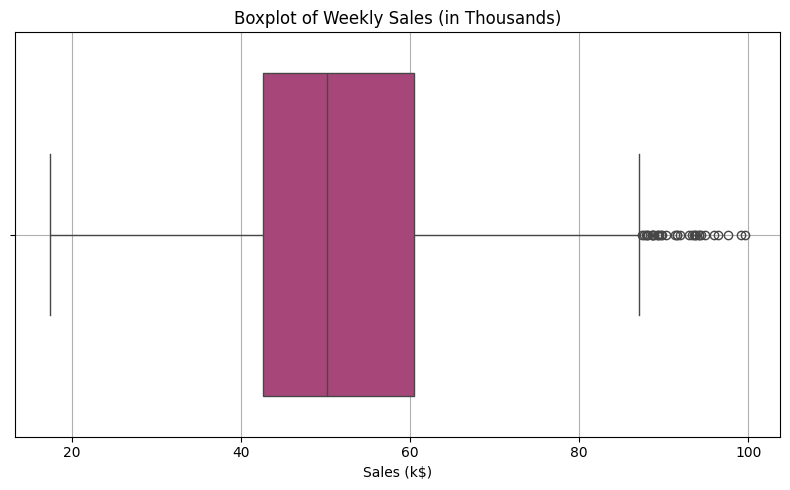

In [12]:
plot_sales_boxplot(df)

The boxplot shows that most weekly sales fall between approximately 40k and 65k, with a median around 53k. 

There are numerous high-value outliers above 85k, indicating that while most stores perform consistently, some experience exceptionally high sales weeks.

**We will keep them for now**, run both a standard ANOVA and a non-parametric test like Kruskal-Wallis for comparison.

I can also run the analysis again after removing values above the 95th percentile, just to validate your findings.

sns.set_palette("magma")

plt.figure(figsize=(9, 6))
sns.boxplot(data=df, x='Promotion', y='SalesInThousands')
plt.title("Sales Distribution by Promotion Type")
plt.xlabel("Promotion Type")
plt.ylabel("Weekly Sales (in Thousands)")
plt.grid(True)
plt.tight_layout()
plt.show()

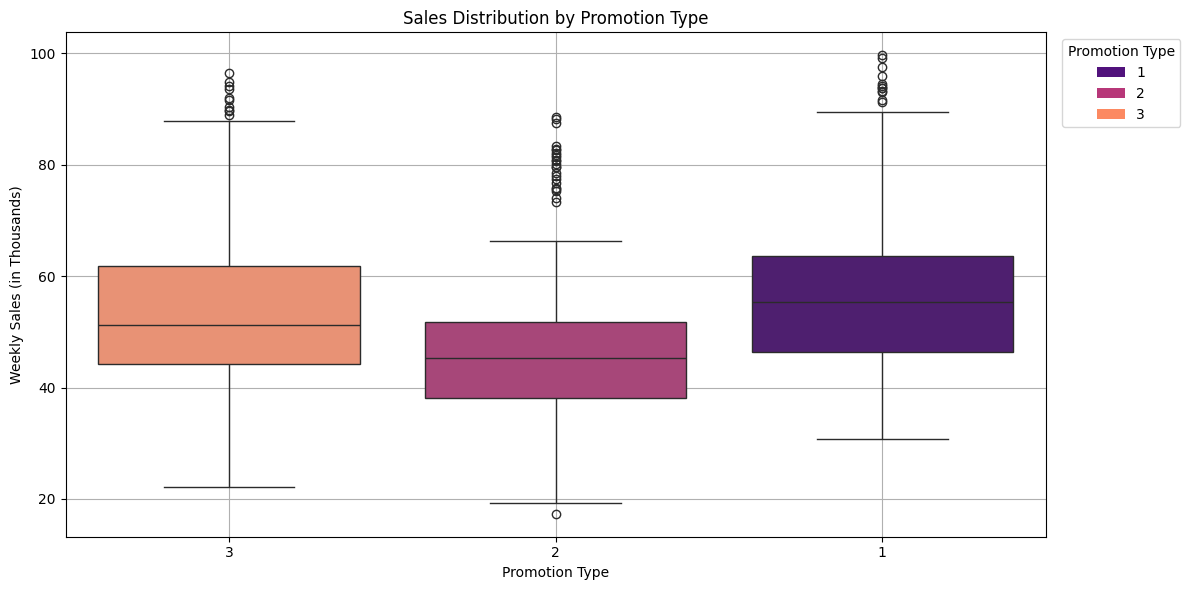

In [13]:
plot_promotion_sales_boxplot(df)

1. The boxplot reveals that Promotion 1 tends to generate the highest median sales (around 60k), followed by Promotion 2 and Promotion 3, which show similar distributions but lower medians. 

2. While there is a notable spread in the data, Promotion 3 displays the most significant presence of outliers above 85k, indicating some extreme sales weeks that may reflect special cases or highly successful campaigns. 

**Outliers might be true reflections of strong promotion performance,** especially if they're consistent with the promotion’s purpose. I don’t want to remove them, so I will use median-based or non-parametric tests (like Kruskal-Wallis) that aren’t affected as much by outliers later in the analysis.

##  Correlation Analysis

Understanding these relationships helps identify which factors may influence sales and informs our further analysis of promotion effectiveness.

The heatmap below displays pairwise correlations between numeric variables.

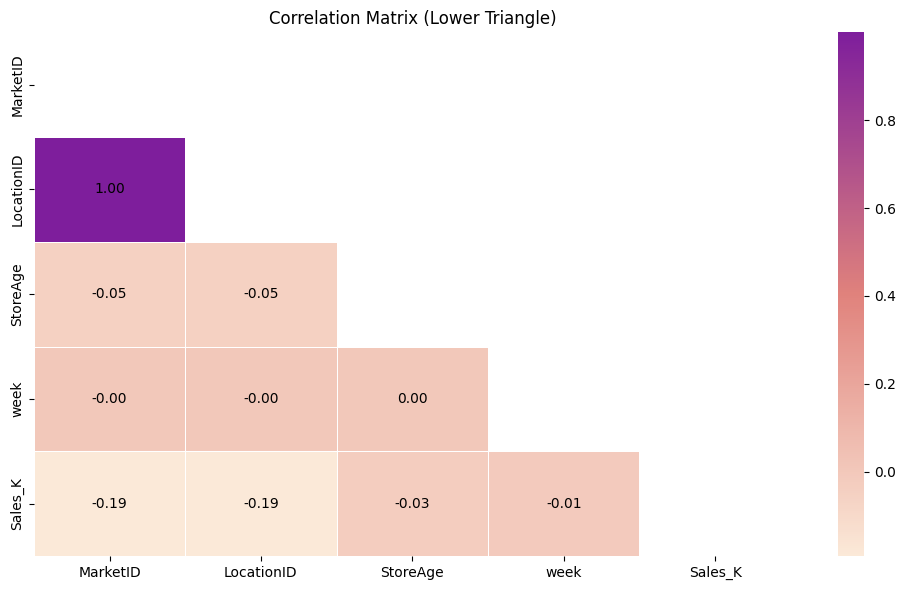

In [14]:
plot_correlation_heatmap(df)

**Observations:**

No strong correlations were found among the numeric features.

The highest absolute correlations are:

1. SalesInThousands has a weak negative correlation with MarketID and LocationID (−0.19), suggesting market-specific variations may influence sales slightly.

2. Promotion shows a very weak negative correlation with SalesInThousands (−0.06), indicating limited direct linear impact.

3. AgeOfStore and week have near-zero correlation with sales, suggesting they do not systematically influence weekly performance.



## Sample Ratio Mismatch Check

Counting actual number of samples per promotion group :

In [15]:
observed_counts = df["Promotion"].value_counts().sort_index().values

Assuming equal distribution (expected counts) :


In [16]:
total = observed_counts.sum()
expected_counts = [total / len(observed_counts)] * len(observed_counts)


Running chi-square test :

In [17]:
chi2, p_srm = chisquare(f_obs=observed_counts, f_exp=expected_counts)

print("SRM Check (Sample Ratio Mismatch):")
print(f"Observed: {observed_counts}")
print(f"Expected: {expected_counts}")
print(f"Chi² = {chi2:.2f}, p-value = {p_srm:.4f}")

SRM Check (Sample Ratio Mismatch):
Observed: [172 188 188]
Expected: [np.float64(182.66666666666666), np.float64(182.66666666666666), np.float64(182.66666666666666)]
Chi² = 0.93, p-value = 0.6268


**Conclusion of SRM check:** 

Since the p-value is greater than 0.05, **we do not detect any sample ratio mismatch**. Group assignments appear to be balanced, and I can proceed with the analysis.

## Statistical Testing: Do Promotions Significantly Differ?


I’ll compare average weekly sales across the 3 promotions:

a. ANOVA Test (parametric)
Tests if there is a significant difference in means

Assumes normal distribution and equal variance

b. Kruskal-Wallis Test (non-parametric)
Doesn’t assume normality, uses medians

Good backup if outliers or skew are concerns



Ensuring Promotion is numeric :


In [18]:
df["Promotion"] = df["Promotion"].astype(int)

### Checking if data is normally distributed

Grouping Data by Promotion Type :

In [19]:
group1 = df[df["Promotion"] == 1]["Sales_K"]
group2 = df[df["Promotion"] == 2]["Sales_K"]
group3 = df[df["Promotion"] == 3]["Sales_K"]

Running Shapiro-Wilk test on these groups :

In [20]:
print("Shapiro-Wilk test for Promotion 1:", shapiro(group1))
print("Shapiro-Wilk test for Promotion 2:", shapiro(group2))
print("Shapiro-Wilk test for Promotion 3:", shapiro(group3))

Shapiro-Wilk test for Promotion 1: ShapiroResult(statistic=np.float64(0.9152999060992891), pvalue=np.float64(1.97726450444774e-08))
Shapiro-Wilk test for Promotion 2: ShapiroResult(statistic=np.float64(0.914509809064016), pvalue=np.float64(5.4570996662742616e-09))
Shapiro-Wilk test for Promotion 3: ShapiroResult(statistic=np.float64(0.9207683041490251), pvalue=np.float64(1.499465926119378e-08))


All p-values are well below 0.05, which means: **I reject the null hypothesis of normality.** 
The distributions of sales in all three groups are not normal. I can’t fully trust parametric tests like ANOVA.

### ANOVA Test

Building linear model and running ANOVA :

In [21]:
model = ols("Sales_K ~ C(Promotion)", data=df).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                     sum_sq     df          F        PR(>F)
C(Promotion)   11449.174291    2.0  21.953486  6.765849e-10
Residual      142114.105414  545.0        NaN           NaN


**ANOVA Results:**

F-value is high it suggests the group means are far apart.

p-value = 6.77e-10, way below 0.05, this is statistically significant.

The ANOVA shows a significant difference in average sales between promotion types (F=21.95, p<0.001).  
This means at least one promotion performs differently, but I need a post-hoc test to see which ones (I will do it later in the analysis).

This result supports the alternative hypothesis (H1).

### Kruskal-Wallis Test

To compare sales performance across different promotion strategies, we first group the weekly sales data (Sales_K`) by promotion type. Now let's run Kruskal test :

In [22]:
kruskal_result = kruskal(group1, group2, group3)
print(kruskal_result)

KruskalResult(statistic=np.float64(53.29475169322799), pvalue=np.float64(2.674186626669782e-12))



**Kruskal-Wallis Results:**

Since p < 0.05, the result is statistically significant.

This rejects the null hypothesis (H₀: all promotion groups have equal median sales)

The Kruskal-Wallis test confirms a significant difference in median sales between promotion types (H=53.29, p<0.001), supporting the ANOVA result without assuming normality.

**Conclusion from both tests:** Both **ANOVA** and **Kruskal-Wallis** tests indicate that **promotion type has a statistically significant effect on weekly sales**.

- **ANOVA p-value**: 6.77e-10 = strong evidence against the null hypothesis.
- **Kruskal-Wallis p-value**: 2.67e-12 = confirms the result using a non-parametric test.

However, since the Shapiro-Wilk test showed that the sales data is **not normally distributed**, the **Kruskal-Wallis test provides more reliable evidence** in this case.

I can confidently conclude that **at least one promotion group performs differently** in terms of weekly sales.

## Post-hoc Test: Where Are the Differences?

A post-hoc test (Latin for "after this") is a follow-up test you run after finding a statistically significant result in a test that compares multiple groups  like ANOVA.

### Tukey's HSD Test

Tukey HSD test is a parametric post-hoc test. It assumes normal distribution of the data within each group, so I have to keep that mind and run The Mann-Whitney U Test later on.

Running Tukey's HSD to compare promotion pairs :


In [23]:
tukey_result = pairwise_tukeyhsd(
    endog=df["Sales_K"], groups=df["Promotion"], alpha=0.05
)

print(tukey_result.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.7696    0.0 -14.7738 -6.7654   True
     1      3  -2.7345 0.2444  -6.7388  1.2697  False
     2      3   8.0351    0.0   4.1208 11.9493   True
-----------------------------------------------------


**Tukey's HSD results:**
- **Promotion 1 vs 2**: Significant difference (Promotion 1 performs better)
- **Promotion 1 vs 3**: No significant difference
- **Promotion 2 vs 3**: Significant difference (Promotion 3 performs better)

Promotion 2 is significantly less effective than both Promotion 1 and 3.

This result supports alternative hypothesis.

### The Mann-Whitney U Test

Preparing groups :

In [24]:
promotion_groups = {
    1: df[df["Promotion"] == 1]["Sales_K"],
    2: df[df["Promotion"] == 2]["Sales_K"],
    3: df[df["Promotion"] == 3]["Sales_K"],
}

Listing of groups and labels :

In [25]:
groups = [group1, group2, group3]
labels = ["1", "2", "3"]

Bonferroni correction for 3 comparisons :

In [26]:
alpha = 0.05
bonferroni_alpha = alpha / 3

Running tests for all pairs and then converting to DataFrame :

In [27]:
results = []
for (i, g1), (j, g2) in combinations(enumerate(groups), 2):
    stat, p = mannwhitneyu(g1, g2, alternative="two-sided")
    results.append(
        {
            "Group 1": labels[i],
            "Group 2": labels[j],
            "U statistic": stat,
            "p-value": p,
            "Significant (Bonferroni)": p < bonferroni_alpha,
        }
    )

results_df = pd.DataFrame(results)
print(results_df)

  Group 1 Group 2  U statistic       p-value  Significant (Bonferroni)
0       1       2      22957.5  5.845935e-12                      True
1       1       3      18247.0  3.508410e-02                     False
2       2       3      12093.0  1.197008e-07                      True


**The Mann-Whitney U tests results:**

 Using a Bonferroni-adjusted significance level of **0.0167**, I tested all pairwise combinations of promotion types:

- **Promotion 1 vs 2**: p = 5.85e-12 = **Significant**
- **Promotion 1 vs 3**: p = 0.035 = **Not significant**
- **Promotion 2 vs 3**: p = 1.20e-07 = **Significant**

Promotion 2 differs significantly from both Promotion 1 and Promotion 3 in terms of weekly sales.

Promo 1 vs 2 and Promo 2 vs 3 rejects the null hypothesis. These comparisons support the alternative hypothesis (H1): sales distributions are different.

Promo 1 vs 3 fail to reject H0: there's no strong evidence of a difference.

**Conclusion from both tests:** 

Tests confirms that **promotion type significantly affects weekly sales**.  
- **Promotion 1** performs best overall  
- **Promotion 2** performs the worst  
- **Promotion 3** sits in between  

The **Mann-Whitney U test** detects significant differences between all pairs **except between Promotion 1 and 3**.  
The **Tukey HSD test** also finds **no significant difference between Promotion 1 and 3**, supporting the same conclusion despite its parametric nature.

Results reject H0 (Except when comparing Promo 1 and Promo 3) and support the alternative hypothesis.  

Overall, Promotion 2 consistently underperforms compared to the others, making it the least effective promotion strategy.

## Visual Comparison by Promotion Type

### Violin plots (distribution insight)

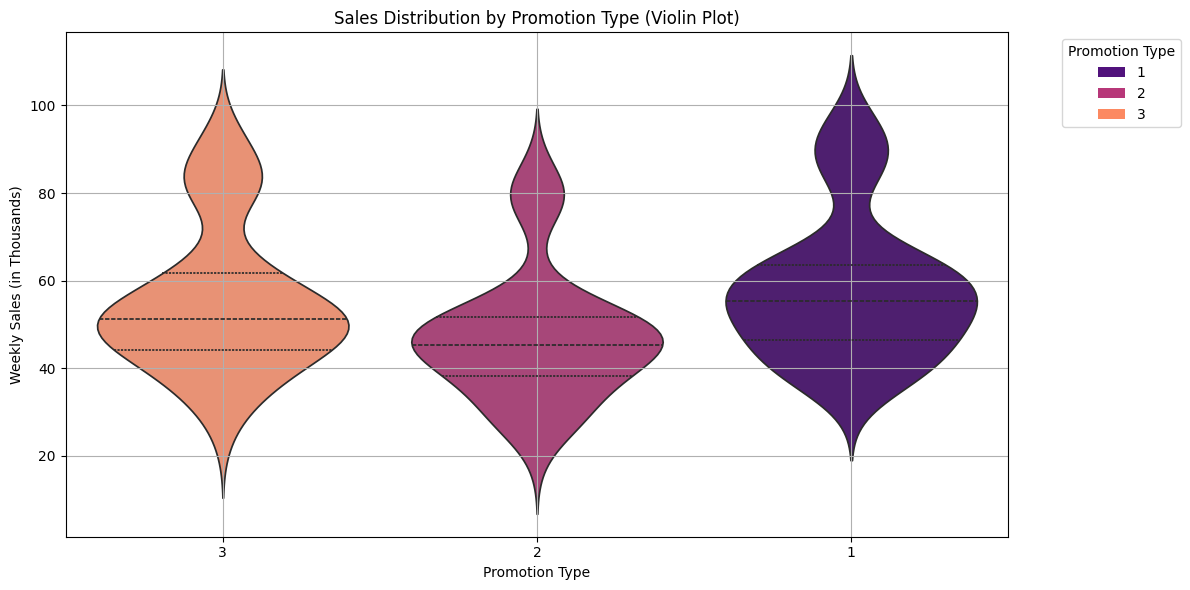

In [28]:
plot_promotion_violinplot(df)

The violin plot shows that **Promotion 1** has the highest and most concentrated distribution of sales, with a strong central peak.  
**Promotion 2** shows a lower and flatter distribution, indicating weaker and more varied sales performance.  
**Promotion 3** sits in between, with more spread but still a noticeable peak around the median — confirming Promotion 1's lead in effectiveness.

This supports statisticals tests results.

### Point Plot By Mean Weekly Sales With 95% Confidence Intervals

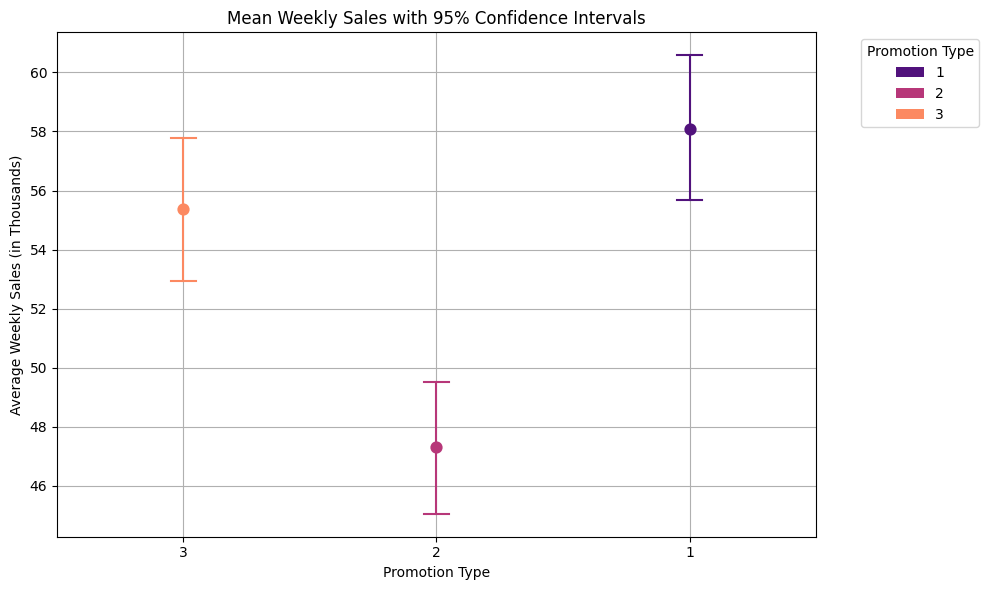

In [29]:
plot_promotion_pointplot(df)

**Observations:**

The plot shows that **Promotion 1** has the highest mean weekly sales (~58k) with a narrow 95% confidence interval, indicating both strong and consistent performance.  

**Promotion 2** has the lowest average sales (~47k), with no overlap in confidence intervals compared to the others, suggesting a statistically significant difference.  

**Promotion 3** sits in between, but is notably closer to Promotion 1, reinforcing the earlier finding that Promotion 2 is the weakest performer.

### Conclusion on both graphs

Both the violin plot and the point plot confirm that **Promotion 1 consistently outperforms the others**, showing the highest concentration and mean of weekly sales.  

**Promotion 2 performs the worst**, with lower median, mean, and wider distribution, indicating less effective and more variable results.  

**Promotion 3** is moderately effective, closer to Promotion 1 than 2, but still statistically different — making **Promotion 1 the most reliable and impactful choice** overall.

## Promotion Effectiveness by Market Size

Does promotion work better in certain market sizes?

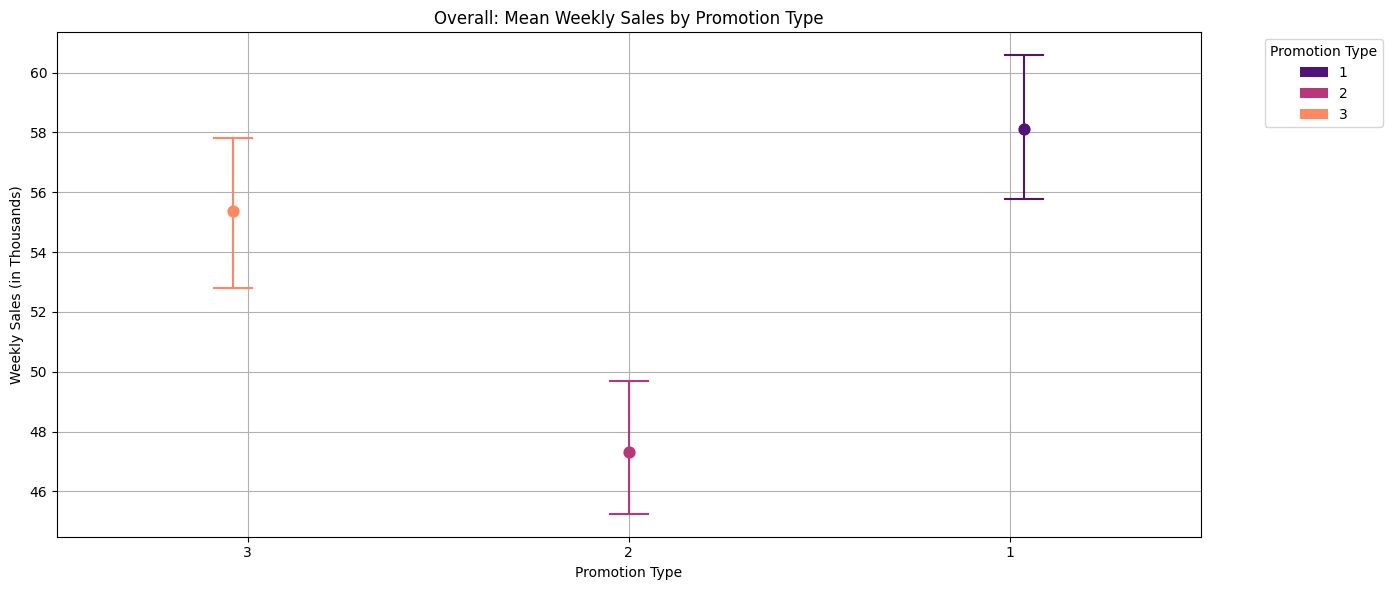

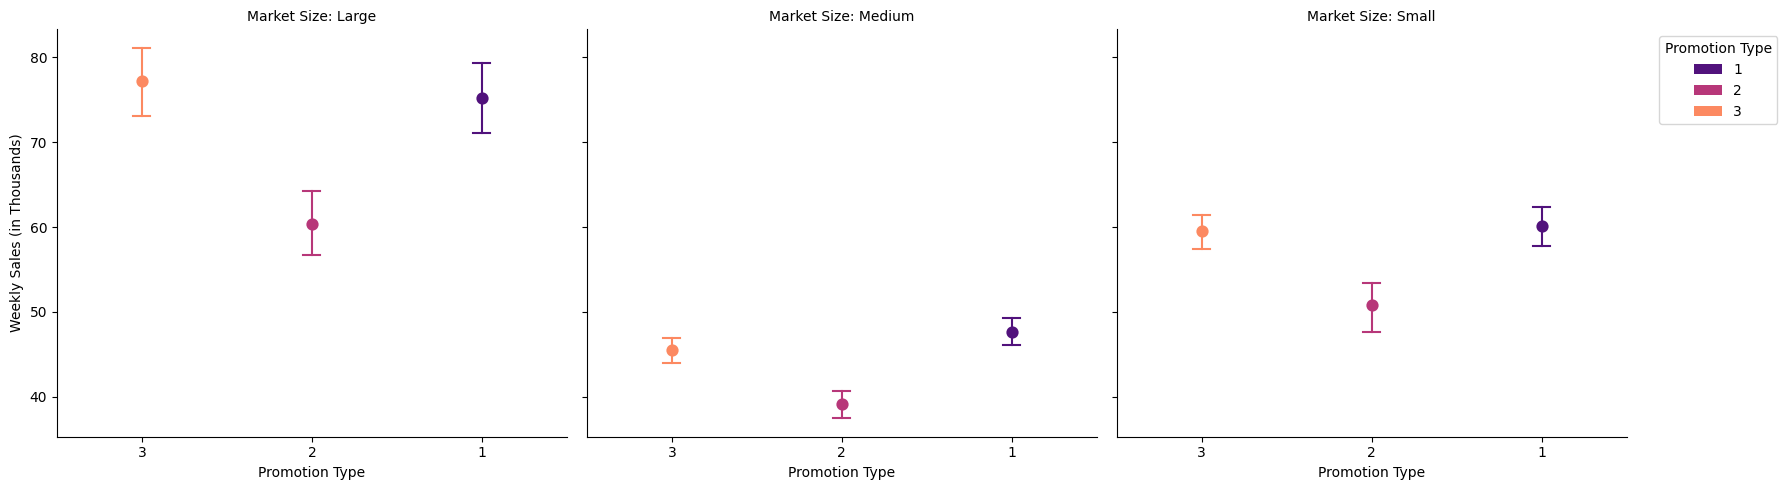

In [30]:
plot_overall_and_faceted_pointplots(df)

**Observations:**

The overall plot confirms that **Promotion 1** consistently drives the highest weekly sales, followed by Promotion 3, while **Promotion 2 significantly underperforms**.

When split by market size:
- In **large markets**, Promotion 3 leads slightly, with Promotion 1 close behind — both clearly outperform Promotion 2.
- In **medium markets**, Promotion 1 is the best, but the differences are smaller.
- In **small markets**, Promotion 3 performs best, followed by 1, again with Promotion 2 last.

This suggests Promotion 1 is the most **universally effective**, while Promotion 3 may perform **best in smaller or larger markets**, and Promotion 2 is **consistently the weakest** across all sizes.

### Kruskal-Wallis Test By Market Size

I will use Kruskal-Wallis to detect promotion impact within each market size.

Containers for results :

In [31]:
kruskal_market_results = {}

Runing Kruskal-Wallis test for each Market Size group :

In [32]:
for market in df["MarketSize"].unique():
    market_df = df[df["MarketSize"] == market]

    group1 = market_df[market_df["Promotion"] == 1]["Sales_K"]
    group2 = market_df[market_df["Promotion"] == 2]["Sales_K"]
    group3 = market_df[market_df["Promotion"] == 3]["Sales_K"]

    stat, pval = kruskal(group1, group2, group3)
    kruskal_market_results[market] = {"Statistic": stat, "p-value": pval}

kruskal_market_results

{'Medium': {'Statistic': np.float64(45.66905272176446),
  'p-value': np.float64(1.210852393530555e-10)},
 'Small': {'Statistic': np.float64(21.046561565107865),
  'p-value': np.float64(2.6902783992842076e-05)},
 'Large': {'Statistic': np.float64(41.02960567436476),
  'p-value': np.float64(1.231783352943042e-09)}}

**Kruskal-Wallis tests results by market size:**

In all market sizes, the p-values are far below 0.05 — meaning we reject the null hypothesis (H0).

The effect is most robust in Medium and Large markets where sample sizes are more reliable.

Small markets, while significant, should still be interpreted with care due to fewer observations.

### Conclusion: Promotion Effectiveness by Store Age

Promotion type significantly affects sales across all market sizes.

The effect is strongest and most consistent in medium and large markets.

Results reinforce the pattern :

Promotion 1 as the best default, it's the best choice for medium and large markets.

Promotion 3 in specific niche contexts, it's the best choice for small markets, but is good option for large and medium markets as well.

Promotion 2 should be reconsidered due to underperformance.

## Promotion Effectiveness by Store Age

Are younger/older stores more responsive?

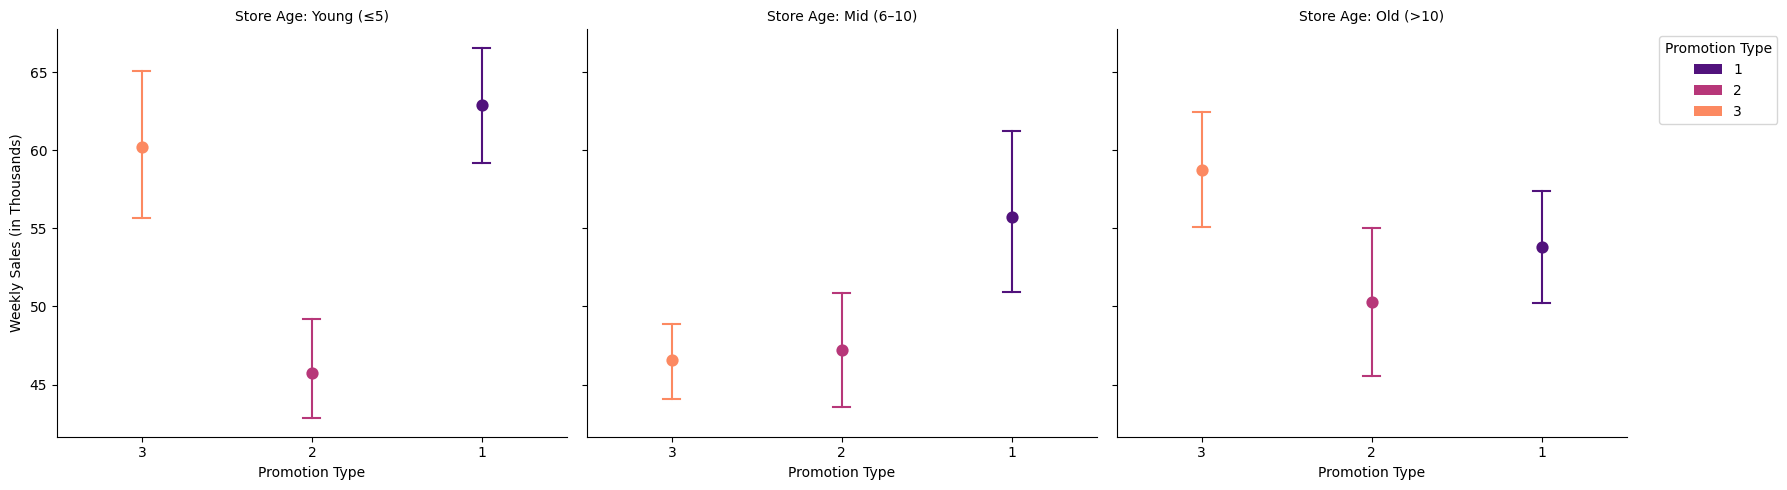

In [33]:
plot_promotion_by_agegroup(df)

In **young stores (≤5 years)**, Promotion 1 clearly drives the highest sales, followed closely by Promotion 3, while Promotion 2 lags behind.

In **mid-aged stores (6–10 years)**, Promotion 1 maintains the lead, but the differences between all three are narrower and less distinct.

In **older stores (>10 years)**, Promotion 3 becomes the top performer, with Promotion 1 just behind and Promotion 2 still the weakest.

**Graph Conclusion:** **Promotion 1 is the most reliable overall**, especially in younger and mid-aged stores, while **Promotion 3 may be more effective in older stores**. Promotion 2 underperforms across all age groups.

### Kruskal-Wallis Test By The Age Group

We will run Kruskal-Wallis test to understand how the effectiveness of each promotion changes depending on the age of the store. It might reveal deeper patterns.

Container to store results :

In [34]:
kruskal_results = {}

Creating Age groups :

In [35]:
bins = [0, 5, 10, df["StoreAge"].max()]
labels = ["Young (≤5)", "Mid (6–10)", "Old (>10)"]
df["AgeGroup"] = pd.cut(df["StoreAge"], bins=bins, labels=labels, right=True)

Running Kruskal test, looping through each AgeGroup :

In [36]:
for group in df["AgeGroup"].unique():
    group_df = df[df["AgeGroup"] == group]

    group1 = group_df[group_df["Promotion"] == 1]["Sales_K"]
    group2 = group_df[group_df["Promotion"] == 2]["Sales_K"]
    group3 = group_df[group_df["Promotion"] == 3]["Sales_K"]

    stat, p = kruskal(group1, group2, group3)
    kruskal_results[group] = {"Statistic": stat, "p-value": p}

for age_group, result in kruskal_results.items():
    print(f"\nAge Group: {age_group}")
    print(
        f"Kruskal-Wallis statistic = {result['Statistic']:.2f}, p-value = {result['p-value']:.4f}"
    )


Age Group: Young (≤5)
Kruskal-Wallis statistic = 44.97, p-value = 0.0000

Age Group: Old (>10)
Kruskal-Wallis statistic = 10.38, p-value = 0.0056

Age Group: Mid (6–10)
Kruskal-Wallis statistic = 7.03, p-value = 0.0297


Young Stores (≤5 years)
- **Statistic**: 44.97  
- **p-value**: < 0.0001  
Strong evidence that promotion type significantly impacts sales in young stores.

Mid-Aged Stores (6–10 years)
- **Statistic**: 7.03  
- **p-value**: 0.0297  
Moderate evidence of a statistically significant difference in sales between promotions.

Old Stores (>10 years)
- **Statistic**: 10.38  
- **p-value**: 0.0056  
Also statistically significant, though slightly weaker than in younger stores.


**Kruskal Test Conclusion:**

Promotion type **influences weekly sales in all store age groups**, but the **effect is strongest in the youngest stores**. This suggests that newer stores may be **more responsive to marketing strategies**, possibly due to lower brand loyalty or greater need for visibility.

These Kruskal-Wallis test results (and graph above) support the alternative hypothesis (H1)

### Conclusion: Promotion Effectiveness by Store Age


Graphs and statistical tests confirm that promotion type has a significant impact on weekly sales across all store age groups.

- **Promotion 1** is the most consistently effective, especially in young (≤5 years) and mid-aged (6–10 years) stores, where it significantly outperforms both Promotion 2 and Promotion 3.
- In older stores (>10 years), **Promotion 3 becomes more competitive and may even outperform Promotion 1 in some instances, suggesting that older locations respond differently to promotional strategies.
- **Promotion 2 underperforms across all age groups**, making it the least effective promotion overall.

These insights suggest that tailoring promotion strategies by store age could lead to improved sales performance.


## Final Conclusion & Recommendation

#### Goal:
To evaluate which **promotion type (1, 2, or 3)** is most effective in increasing weekly sales across various store and market conditions.

#### Analysis Result
Promotion 1 is the most effective overall, Promotion 3 is context-dependent, and Promotion 2 consistently underperforms.

#### Analysis progress:
1.Data exploration and cleaning ensured reliable inputs.

2. SRM Check confirmed fair group distribution (χ² = 0.93, p = 0.6268).

3. Statistical testing:

   - ANOVA and Kruskal-Wallis tests confirmed significant overall differences.

   - Post-hoc analyses (Tukey, Mann-Whitney U) pinpointed where differences existed.

4. Visualizations (boxplots, violin plots, point plots) illustrated differences in sales performance across promotions.

5. Segment-level analysis:

   -By Store Age: Young (≤5), Mid (6–10), Old (>10)

   -By Market Size: Small, Medium, Large

   -Kruskal-Wallis tests were conducted for both segments, confirming that promotion effectiveness significantly varies across groups
---

#### Key Findings:
- **Promotion 1 consistently delivers the highest weekly sales** across most market sizes and age groups.
- **Promotion 3 performs well in specific contexts**, such as small markets and older stores.
- **Promotion 2 underperforms in all tested scenarios**.
- **Kruskal-Wallis tests** within segments confirmed that promotion impact varies significantly by store age and market size.

---

#### Recommendation:
- **Use Promotion 1 as the default strategy**, especially in young and mid-aged stores and in medium to large markets.
- **Consider Promotion 3 in older stores or small markets**, where it shows stronger performance.
- **Reassess or phase out Promotion 2**, as it consistently yields the weakest results.
- Tailor future marketing efforts based on **store age and market size** to maximize campaign impact.

This data-driven approach ensures more strategic, profitable promotion planning across your retail network.







